In [1]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [4]:
# convierte las series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [5]:
# Cargar los datos de EEG para los cuatro usuarios
# ... Código para cargar los datos de EEG ...
user1_data = read_csv('AdrianaVillar.csv', header=None)
user2_data = read_csv('Luis Carlos.csv', header=None)
user3_data = read_csv('Elsa.csv', header=None)
user4_data = read_csv('miriamsanchez.csv', header=None)


user1_data.columns = ['Attention','Meditation','Delta','Theta',
           'Low Alpha','Low Beta','High Beta','Low Gamma','High Gamma','Signal','Etiqueta',
           'Timestamp']
user1_data.set_index('Timestamp', inplace=True)
user1_data = user1_data.drop('Etiqueta', axis=1)
user1_data = user1_data.drop('Attention', axis=1)


user2_data.columns = ['Attention','Meditation','Delta','Theta',
           'Low Alpha','Low Beta','High Beta','Low Gamma','High Gamma','Signal','Etiqueta',
           'Timestamp']
user2_data.set_index('Timestamp', inplace=True)
user2_data = user2_data.drop('Etiqueta', axis=1)
user2_data = user2_data.drop('Attention', axis=1)


user3_data.columns = ['Attention','Meditation','Delta','Theta',
           'Low Alpha','Low Beta','High Beta','Low Gamma','High Gamma','Signal','Etiqueta',
           'Timestamp']
user3_data.set_index('Timestamp', inplace=True)
user3_data = user3_data.drop('Etiqueta', axis=1)
user3_data = user3_data.drop('Attention', axis=1)


user4_data.columns = ['Attention','Meditation','Delta','Theta',
           'Low Alpha','Low Beta','High Beta','Low Gamma','High Gamma','Signal','Etiqueta',
           'Timestamp']
user4_data.set_index('Timestamp', inplace=True)
user4_data = user4_data.drop('Etiqueta', axis=1)
user4_data = user4_data.drop('Attention', axis=1)

In [6]:

# Dividir los datos en conjuntos de entrenamiento y evaluación (2 usuarios para entrenamiento, 2 usuarios para evaluación)
train_users = [user2_data, user3_data , user4_data]
  # Datos de entrenamiento de dos usuarios
test_users = [user1_data] 
# Unir los datos de los usuarios para entrenamiento y evaluación
train_data = concatenate(train_users, axis=0)
test_data = concatenate(test_users, axis=0)

# ensure all data is float
train_data = train_data.astype('float32')
test_data = test_data.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.transform(test_data)

reframed_train = series_to_supervised(scaled_train, 1, 1)
reframed_test = series_to_supervised(scaled_test, 1, 1)

reframed_train.drop(reframed_train.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
reframed_test.drop(reframed_test.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)

print(reframed_train.head())

# specify the number of lag hours and number of features
#n_hours = 3
n_features = train_data.shape[1]

'''# borra las columnas que no predecimos
reframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)
print(reframed.head())'''


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.329897   0.101288   0.314859   0.095133   0.047867   0.042219   
2   0.144330   0.013126   0.048888   0.010659   0.019229   0.006687   
3   0.268041   0.688501   0.017298   0.060768   0.117227   0.104885   
4   0.412371   0.000808   0.002150   0.001101   0.036367   0.007284   
5   0.515464   0.003266   0.003859   0.012138   0.036087   0.038685   

   var7(t-1)  var8(t-1)  var9(t-1)   var1(t)  
1   0.439192   0.396639   0.201427  0.144330  
2   0.064947   0.037658   0.032286  0.268041  
3   0.125974   0.171082   0.310866  0.412371  
4   0.009496   0.020370   0.009491  0.515464  
5   0.091832   0.120029   0.051750  0.659794  


'# borra las columnas que no predecimos\nreframed.drop(reframed.columns[[10,11,12,13,14,15,16,17]], axis=1, inplace=True)\nprint(reframed.head())'

In [7]:
...
# divide la BBDD en entrenamiento y validaci´n
values_train = reframed_train.values
values_test = reframed_test.values

#n_train = 500


#train = values[:n_train, :]
#test = values[n_train:, :]
# dividir en input y outputs
train_X, train_y = values_train[:, :-1], values_train[:, -1]
test_X, test_y = values_test[:, :-1], values_test[:, -1]
# configurar en 3D  [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1306, 1, 9) (1306,) (355, 1, 9) (355,)


In [8]:
...
# diseñar la red
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# entrenar la red
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# GRAFICAS

Epoch 1/50
19/19 - 6s - loss: 0.4414 - val_loss: 0.4105 - 6s/epoch - 311ms/step
Epoch 2/50
19/19 - 0s - loss: 0.3353 - val_loss: 0.3088 - 159ms/epoch - 8ms/step
Epoch 3/50
19/19 - 0s - loss: 0.2266 - val_loss: 0.2089 - 215ms/epoch - 11ms/step
Epoch 4/50
19/19 - 0s - loss: 0.1522 - val_loss: 0.1439 - 193ms/epoch - 10ms/step
Epoch 5/50
19/19 - 0s - loss: 0.1315 - val_loss: 0.1267 - 157ms/epoch - 8ms/step
Epoch 6/50
19/19 - 0s - loss: 0.1241 - val_loss: 0.1203 - 128ms/epoch - 7ms/step
Epoch 7/50
19/19 - 0s - loss: 0.1159 - val_loss: 0.1146 - 154ms/epoch - 8ms/step
Epoch 8/50
19/19 - 0s - loss: 0.1084 - val_loss: 0.1088 - 145ms/epoch - 8ms/step
Epoch 9/50
19/19 - 0s - loss: 0.1027 - val_loss: 0.1040 - 140ms/epoch - 7ms/step
Epoch 10/50
19/19 - 0s - loss: 0.0982 - val_loss: 0.0997 - 174ms/epoch - 9ms/step
Epoch 11/50
19/19 - 0s - loss: 0.0945 - val_loss: 0.0963 - 150ms/epoch - 8ms/step
Epoch 12/50
19/19 - 0s - loss: 0.0917 - val_loss: 0.0933 - 140ms/epoch - 7ms/step
Epoch 13/50
19/19 - 0s -

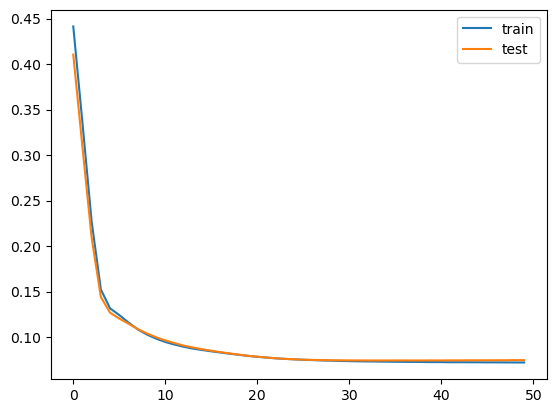

In [9]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

pyplot.savefig('Meditation_1.png')

pyplot.show()

In [10]:
...
# hacer una predicción
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invertir la escala para la previsión
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invertir la escala para el actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calcular RMSE
rmse = mean_squared_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)

12/12 [==============================] - 1s 2ms/step
Test RMSE: 87.104


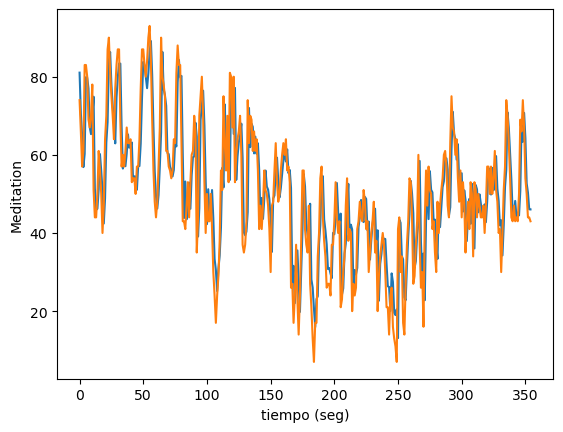

In [13]:
pyplot.plot(inv_yhat)
pyplot.plot(inv_y)
pyplot.gca().set_xlabel('tiempo (seg)')
pyplot.gca().set_ylabel('Meditation')
pyplot.savefig('Prediccion_Med_1.png')


In [12]:
import math
sqrmse = math.sqrt(rmse)
print('Test RMSE: %.3f' % sqrmse)

Test RMSE: 9.333
